# Identificando Entidades Nomeadas
Neste capítulo vamos treinar um identificador de Entidades (NER) nomeadas usando a biblioteca [Spacy](https://spacy.io). A partir deste capítulo vamos importar também funções que já criamos anteriormente, e que encontram-se reproduzidas em  [dhbbmining.py](dhbbmining.py)

In [1]:
import os, glob, pickle
import spacy
from spacy import displacy
from sqlalchemy import create_engine
from dhbbmining import *
import ipywidgets as widgets

Para utilizar o spacy em um corpus na lingua portuguesa, vamos primeiro importar o modelo liguístico do português

In [2]:
nlp = spacy.load("pt_core_news_sm")

Em seguida podemos carregar os verbetes bográficos que salvamos no nosso banco SQLite.

In [3]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
#dhbb = pd.read_sql_table('resultados')
biograficos = pd.read_sql_query('select * from resultados', con=eng)
biograficos.head()

,index,arquivo,title,natureza,sexo,cargos,corpo
0,0,1.text,"COELHO, Machado",biográfico,m,\n - dep. fed. DF 1927-1929 \n - dep. fed. DF ...,\n\n«José Machado Coelho de Castro» nasceu em ...
1,1,10.text,"ABÍLIO, Armando",biográfico,m,\n - dep. fed. PB 1995-1999\n - dep. fed. PB ...,\n\n«Armando Abílio Vieira» nasceu em Itaporan...
2,2,100.text,"ALEIXO, Pedro",biográfico,m,\n - const. 1934\n - dep. fed. MG 1935-1937\n ...,"\n\n«Pedro Aleixo» nasceu em São Caetano, dist..."
3,3,1000.text,"CAMPOS, Eduardo",biográfico,m,\n - dep. fed. PE 1995\n - dep. fed. PE 1998-...,\n\n«Eduardo Henrique Accioly Campos» nasceu e...
4,4,1001.text,"CAMPOS, Eleazar Soares",biográfico,m,\n - magistrado\n - interv. MA 1945-1946\n,\n\n«Eleazar Soares Campos» nasceu em São Luís...


Para começar a utilizar o Spacy, precisamos primeiro precisamos processar o texto. Nesta passagem várias análises linguísticas são realizadas.

In [4]:
doc = nlp(biograficos.corpo[0].strip())
type(doc)

spacy.tokens.doc.Doc

In [5]:
for i, token in enumerate(doc):
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)
    if i>5:
        break
    

« « PUNCT PU|@PU punct « False False
José José PROPN PROPN nsubj Xxxx True False
Machado Machado PROPN PROPN flat:name Xxxxx True False
Coelho Coelho PROPN PROPN flat:name Xxxxx True False
de de ADP PRP|@N< case xx True True
Castro Castro PROPN PROP|@P< nmod Xxxxx True False
» » PUNCT PU|@PU punct » False False


## Testando o NER do Spacy
Como o Spacy já inclui algum suporte à lingua portuguesa, antes de pensar em treinar nosso próprio NER, podemos avaliar a performance do existente. 

Abaixo vamos construir uma visualização interativa da marcação de entidades nos verbetes do DHBB.

In [6]:
from IPython.display import display,clear_output
from ipywidgets import interact

In [7]:
@interact(e=(0, len(biograficos)))
def mostra_ner(e=0):
    text = biograficos.iloc[e].corpo.strip()
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    clear_output(wait=True)

interactive(children=(IntSlider(value=0, description='e', max=7687), Output()), _dom_classes=('widget-interact…

Além da visualização, podemos extrair as entidades presentes em um verbete:

In [8]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

José Machado Coelho de Castro» 1 31 PER
Lorena 42 48 LOC
SP 50 52 LOC
Ginásio Diocesano de São Paulo 67 97 LOC
Faculdade de Ciências Jurídicas 127 158 ORG
Sociais 161 168 LOC
Cunha 220 225 LOC
SP 227 229 LOC
Rio de
Janeiro 263 277 LOC
Distrito Federal 285 301 LOC
Distrito Federal 357 373 LOC
Câmara 488 494 LOC
Getúlio Vargas 575 589 PER
Ligado 591 597 LOC
Washington Luís 654 669 PER
Guanabara 682 691 LOC
Alcântara 951 960 LOC
Lisboa 965 971 LOC
Getúlio 1050 1057 PER
Vargas 1058 1064 PER
São 1125 1128 LOC
Paulo 1129 1134 LOC
São 1206 1209 LOC
Paulo 1210 1215 LOC
Partido Social Democrático 1231 1257 ORG
PSD 1259 1262 ORG
Assembléia Nacional Constituinte 1284 1316 ORG
ANC 1318 1321 ORG
Carta
 1484 1490 PER
Constituinte 1523 1535 MISC
Congresso 1539 1548 LOC
Comissão Permanente de Obras Públicas da Câmara Federal 1571 1626 ORG
Câmara 1732 1738 ORG
Companhia de Cimento Vale do Paraíba 1784 1820 ORG
Rio de Janeiro 1834 1848 LOC


In [9]:
type(doc.ents[0])

spacy.tokens.span.Span

## Treinando Um identificador de Entidades a partir do DHBB
Identificadores de entidades são algoritmos treinados em corpora manualmente anotados. Como cada corpora possui um conjunto particular de entidades, para uma performance ótima o ideal é treinarmos o modelo no Próprio DHBB. Para este fim utilizaremos os dicionários já disponíveis no DHBB,  juntamente com o índice construído no capítulo 2 para recuperar o contexto de cada entrada dos dicionários.

In [10]:
from whoosh import index 
import os
from whoosh.qparser import QueryParser
from whoosh import qparser

O primeiro passo é abrirmos o nosso indice.

In [11]:
if os.path.exists('indexdir'):
    indice = index.open_dir('indexdir')

In [12]:
indice.doc_count()

6724

In [13]:
def busca(consulta):
    qp = QueryParser("corpo", indice.schema)
    qp.add_plugin(qparser.EveryPlugin())
    query = qp.parse(consulta)
    
    with indice.searcher() as searcher:
        results = [(dict(hit),hit.highlights("corpo")) for hit in searcher.search(query, limit=None)]
    return results

In [14]:
resultados = busca('"filho de"')[0]

Agora já temos os ingredientes necessários para treinar um modelo de entidades usando a biblioteca spacy.

In [15]:
import random, os
from tqdm import tqdm
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding

In [16]:
for verb in biograficos.itertuples():
    print(verb.title)
    break

COELHO, Machado


Primeiro precisamos criar o conjunto de treinamento do modelo. e deve ter  a forma de uma lista como a descrita abaixo.
```python
    TRAIN_DATA = [
        ("nasceu em Itaporanga ( PB ) no dia 29 de dezembro de 1944 , filho de Argemiro Abílio de Sousa", 
         {"entities": [(10, 20, "LOC"), (69, 93, "PERSON")]}
        ),
    ]
```

Como primeira abordagem de treinamento, vamos atualizar o modelo que vem com o spacy adicionando mais um tipo de entidade: "eventos". Posteriormente, o modelo pode continuar a ser incrementado adicionando-se outros tipos de entidade. Vamos também aproveitar as entidades reconhecidas pelo modelo base no corpus do DHBB para reforçar o treinamento do modelo no contexto linguístico do DHBB.

In [17]:
path = "F:/dhbb-master/dic/evento.txt"
path = "../../dhbb/dic/evento.txt"
with open(path, 'r', encoding='utf-8') as f:
    dicio = f.readlines()
#ent.text, ent.start_char, ent.end_char, ent.label_
def gera_dados_treinamento(dicionário, tag):
    data = []
    for verb in tqdm(biograficos.itertuples()):
        texto = verb.corpo
        doc = nlp(texto)
        entdict = {"entities":[(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}
        for evento in dicionário:
            try:
                posini =texto.index(evento)
            except ValueError:
                continue
            posfim = posini + len(evento)
            entdict['entities'].append((posini,posfim, tag))
        data.append((texto, entdict))
    return data
            
            

In [18]:
if os.path.exists('ner_training.pickle'):
    dados = pickle.load(open('ner_training.pickle','rb'))
else:
    dados = gera_dados_treinamento(dicio, "EVT")

7687it [35:17,  3.43it/s]


In [19]:
pickle.dump(dados,open('ner_training.pickle','wb'))

In [20]:
for d in dados[:10]:
    print(d[1])

{'entities': [(3, 33, 'PER'), (44, 50, 'LOC'), (52, 54, 'LOC'), (69, 99, 'LOC'), (129, 160, 'ORG'), (163, 170, 'LOC'), (222, 227, 'LOC'), (229, 231, 'LOC'), (265, 279, 'LOC'), (287, 303, 'LOC'), (359, 375, 'LOC'), (490, 496, 'LOC'), (577, 591, 'PER'), (593, 599, 'LOC'), (656, 671, 'PER'), (684, 693, 'LOC'), (953, 962, 'LOC'), (967, 973, 'LOC'), (1052, 1059, 'PER'), (1060, 1066, 'PER'), (1127, 1130, 'LOC'), (1131, 1136, 'LOC'), (1208, 1211, 'LOC'), (1212, 1217, 'LOC'), (1233, 1259, 'ORG'), (1261, 1264, 'ORG'), (1286, 1318, 'ORG'), (1320, 1323, 'ORG'), (1486, 1492, 'PER'), (1525, 1537, 'MISC'), (1541, 1550, 'LOC'), (1573, 1628, 'ORG'), (1734, 1740, 'ORG'), (1786, 1822, 'ORG'), (1836, 1850, 'LOC')]}
{'entities': [(3, 25, 'PER'), (36, 46, 'LOC'), (48, 50, 'LOC'), (92, 116, 'PER'), (122, 144, 'PER'), (169, 175, 'LOC'), (180, 212, 'LOC'), (213, 247, 'LOC'), (337, 358, 'LOC'), (418, 444, 'ORG'), (446, 449, 'PER'), (533, 542, 'LOC'), (544, 546, 'LOC'), (587, 601, 'LOC'), (751, 754, 'PER'), (84

In [21]:
TEST_DATA = dados[-1000:]
TRAIN_DATA = dados[:-1000]

In [22]:
def main(model="pt_core_news_sm", output_dir="dhbb_nlp", n_iter=100):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("pt")  # create blank Language class
        print("Created blank 'pt' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # reset and initialize the weights randomly – but only if we're
        # training a new model
        if model is None:
            nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)

    # test the trained model
    for text, _ in TRAIN_DATA:
        doc = nlp(text)
        print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
        print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        for text, _ in TRAIN_DATA:
            doc = nlp2(text)
            print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
            print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

In [ ]:
main()

Loaded model 'pt_core_news_sm'
Losses {'ner': 6148187.004867554}


## Similaridade semantica

In [10]:
import numpy as np
import networkx as nx
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
G = nx.Graph()

for i,verb1 in tqdm(enumerate(biograficos.itertuples())):
    for j,verb2 in enumerate(biograficos.itertuples()):
        if j>=i:
            continue
        doc1 = nlp(verb1.corpo)
        doc2 = nlp(verb2.corpo)
        sim = doc1.similarity(doc2)
        print(sim)
        if sim > 0.9:
            G.add_edge(verb1.title, verb2.title, weight=sim)
    if len(G.nodes)>20:
        break
            



0it [00:00, ?it/s]

0.9736412094412655




2it [00:00,  4.01it/s]

0.9692314855554565
0.9887844127611848




3it [00:04,  1.37s/it]

0.9690453424512796
0.9877588312193162
0.988704284126218




4it [00:08,  2.15s/it]

0.9312939874386111
0.8880303304435069
0.8871060491758661
0.8972676949479885




5it [00:11,  2.44s/it]

0.9778979879718187
0.9753462364899442
0.9714444980576168
0.9663467679632937
0.9262295144401926




6it [00:15,  2.88s/it]

0.9592603041086275
0.975532591880615
0.9702362581707359
0.9769561741537794
0.8732849984678037
0.9692377929472659




7it [00:19,  3.23s/it]

0.9321373688948714
0.8950161053840271
0.8954882026612847
0.9071147980548291
0.9237984481520677
0.9481836081569859
0.9120318875779666




8it [00:23,  3.43s/it]

0.9436484836235557
0.9782216219485189
0.9891414470255626
0.9796892200211428
0.8401242902069572
0.9507064622669714
0.9688882565409441
0.8619679527387331




9it [00:59, 13.15s/it]

0.9748167121226012
0.9843483944663809
0.9743991632302015
0.9821984001579731
0.886910283577205
0.96882818445918
0.9887274101027633
0.9074350832940326
0.9674930933492911




10it [01:08, 12.08s/it]

0.9407843243035253
0.962330942146688
0.9644607979500517
0.9764554327746553
0.8712466335069049
0.954183205104085
0.9578722292318408
0.9198054075661106
0.9572893878546672
0.9556852750672585




11it [01:17, 11.20s/it]

0.9709523952805834
0.9824180161628335
0.9813879056029056
0.9905682753054265
0.9059016520110134
0.9670929594732104
0.9696390158818233
0.9193160302814072
0.9675528280338189
0.9807619758015435
0.9804897469129027




12it [01:28, 11.05s/it]

0.974129091747883
0.98092806540998
0.9730809212398651
0.9734594355181105
0.9010761873907738
0.9734884673675149
0.9821564230710962
0.9152155548734985
0.9550457721425507
0.9875564458204222
0.940909910541132
0.9702688337937283




13it [01:39, 10.87s/it]

0.9827894999816637
0.9720316060912974
0.9668176915933375
0.9698890308031304
0.9354013635964981
0.9842963267406089
0.956892814617154
0.9473540475908763
0.9444062830038539
0.9669185878890049
0.950198265833854
0.9723349338711532
0.966422188470771




14it [01:50, 11.13s/it]

0.981132586304402
0.9815047779409996
0.9783434893384498
0.97677772538701
0.9101473003305437
0.9721315341369298
0.9731784459982892
0.9151609734377093
0.9548278413255117
0.9841427013827381
0.9414463814057725
0.9729626095236181
0.9954757296113066
0.9697355226716522




15it [02:02, 11.38s/it]

0.9750118779764058
0.9826250405817543
0.978151388734338
0.9852927523365185
0.9121888789328934
0.9862560542668121
0.9827794680472961
0.9427137514629921
0.9612477605606814
0.9842285427085684
0.9755486915900998
0.9848907434531723
0.9821222880320676
0.978869223936925
0.9814983394217695




16it [02:17, 12.22s/it]

0.9656398823983473
0.969678042772926
0.970864767294153
0.9774371578737523
0.9080779275061355
0.9580085885467087
0.9731642283364211
0.9004763446067745
0.9572270317214112
0.9767716452428961
0.9403238456020123
0.9706329435270021


KeyboardInterrupt: 

C:\Users\flavio.codeco.coelho\.conda\envs\curso\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


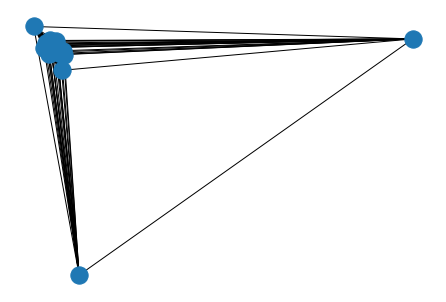

In [21]:
nx.draw(G, pos=nx.spectral_layout(G, weight='similarity'));

In [23]:
nx.write_gexf(G,'dhbb.gexf')